# IMDB Movie Dataset Cleanup & EDA

The aim of this notebook is to cleanup and get the IMDB movie dataset ready for predicitve analysis

### I) Setting Up

In [1]:
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette("Set2")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
imdb_df = pd.read_csv('imdb_df_raw.csv', sep='\t', encoding='utf-8')

### II)  EDA and missing record investigation

In [3]:
imdb_df.head(2)

,Unnamed: 0,id,title,genre,runtime,release_dt,budget,us_boxoffice_gross,mpaa_rating,user_rating,total_votes,critic_score
0,0,1,Pacific Rim,"Action, Adventure, Sci-Fi",131,12 July 2013,"$190,000,000",$101.80M,PG-13,7.0,409200,64
1,1,2,Prisoners,"Crime, Drama, Mystery",153,20 September 2013,"$46,000,000",$61.00M,R,8.1,453418,74


In [4]:
imdb_df.columns

Index(['Unnamed: 0', 'id', 'title', 'genre', 'runtime', 'release_dt', 'budget',
       'us_boxoffice_gross', 'mpaa_rating', 'user_rating', 'total_votes',
       'critic_score'],
      dtype='object')

In [5]:
# remove irrelevant columns
imdb_df.drop(columns ='Unnamed: 0', inplace=True)

In [6]:
imdb_df.shape

(4392, 11)

In [7]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4392 entries, 0 to 4391
Data columns (total 11 columns):
id                    4392 non-null int64
title                 4392 non-null object
genre                 4392 non-null object
runtime               4392 non-null int64
release_dt            4392 non-null object
budget                4392 non-null object
us_boxoffice_gross    4392 non-null object
mpaa_rating           4392 non-null object
user_rating           4392 non-null float64
total_votes           4392 non-null int64
critic_score          4392 non-null int64
dtypes: float64(1), int64(4), object(6)
memory usage: 377.5+ KB


In [8]:
imdb_df.describe()

,id,runtime,user_rating,total_votes,critic_score
count,4392.000000,4392.000000,4392.000000,4.392000e+03,4392.000000
mean,18160.888434,97.495674,5.523520,5.284074e+04,26.001821
std,8009.190144,19.663555,1.404674,1.198650e+05,27.927053
min,1.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,13050.250000,89.000000,4.600000,3.917500e+02,0.000000
50%,20195.500000,96.000000,5.700000,3.297000e+03,20.000000
75%,24474.750000,106.000000,6.600000,5.054050e+04,50.000000
max,29578.000000,219.000000,9.000000,1.852735e+06,96.000000


In [9]:
# Checking for duplicate entries and missing values
dup_cnt, null_cnt = imdb_df.duplicated().sum(), imdb_df.isnull().sum().sum()
print("Number of Duplicate entries = %d, Missing entries = %d" % (dup_cnt, null_cnt))
if(imdb_df.isnull().sum().sum()): print(imdb_df.isnull().sum())

Number of Duplicate entries = 0, Missing entries = 0


### III) Clean Up and Convert Data Types of Variables

#### 1) Budget / Gross

In [10]:
#Remove $ and comma from currency handle abbreviations and convert to int($1.2M -> 1200000)
def currency_str_to_int(amt):
    if isinstance(amt, str):
        amt = amt.replace('$','').replace(',','')
        if amt[-1] == 'M':
            amt = float(amt.replace('M',''))*10**6
    return int(amt)

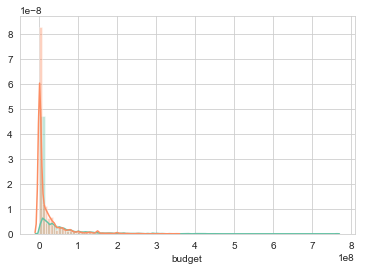

In [11]:
# Fix currencies (budget / gross) - Convert currency fields from string to int and drop erronous values
imdb_df["budget"] = imdb_df["budget"].apply(currency_str_to_int)
imdb_df["us_boxoffice_gross"] = imdb_df["us_boxoffice_gross"].apply(currency_str_to_int)


# Check the plot of budget / gross
sns.distplot(imdb_df['us_boxoffice_gross'])
sns.distplot(imdb_df['budget'])
plt.show()

In [12]:
# looking at movies with < 9999 as budget or gross
# imdb_df.loc[imdb_df[imdb_df.us_boxoffice_gross < 9999].index  & imdb_df[imdb_df.budget < 9999].index]

#### 2) Release month

In [13]:
# Fix release dates - extract release month
# ignore to avoid errors from formats like: 'January 2004' - ref: http://strftime.org/
imdb_df['release_dt'] = pd.to_datetime(imdb_df['release_dt'], format='%d %B %Y', errors = 'coerce')

# Extract month, sort the DF by id to do a forward fill for missing elements
imdb_df['release_month'] = imdb_df['release_dt'].dt.month

# data was populated in the order of release, hence id is indicative of month of release similarity
imdb_df = imdb_df.sort_values(by = 'id')   
imdb_df['release_month'] = imdb_df['release_month'].fillna(method = 'ffill')
print("Fixed %d empty months" % (imdb_df['release_dt'].isnull().sum()))

imdb_df['release_dt'] = imdb_df['release_dt'].fillna(method='ffill')

#imdb_df_clean = imdb_df_clean.drop('release_dt', axis=1)

# converting release month to categories
imdb_df['release_month'] = imdb_df['release_month'].astype(object)

Fixed 283 empty months


In [14]:
# Re-code release month
imdb_df['new_release_month'] = imdb_df['release_month'].replace(
    {1:'Jan', 2:'Feb', 3:'Mar',  4:'Apr',  5:'May',  6:'Jun',
     7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'})

# drop original release_month column
imdb_df = imdb_df.drop('release_month', axis=1)

#### 3) Runtime

In [15]:
# Dealing with runtime - forward fill missing runtimes
missing_runtime = (imdb_df['runtime'] == 0).sum()

# To keep runtime similar within a genre, sort the DF to do a forward fill for missing elements
imdb_df = imdb_df.sort_values(by = 'genre')
imdb_df['runtime'] = imdb_df['runtime'].replace(0, np.nan)
imdb_df['runtime'] = imdb_df['runtime'].fillna(method = 'ffill')
print("Fixed %d empty runtimes" % (missing_runtime.sum()))

Fixed 65 empty runtimes


#### 4) mpaa_rating (categorical variable)

In [16]:
# merge 'Not Rated', 'Unrated', 'Empty'
imdb_df['mpaa_rating'] = imdb_df['mpaa_rating'].map(lambda x: 'Not Rated' if x == 'Empty' or x == 'Unrated' else x)
# merge 'NC-17', 'TV-MA' with 'R
imdb_df['mpaa_rating'] = imdb_df['mpaa_rating'].map(lambda x: 'R' if x == 'NC-17' or x == 'TV-MA' or x == 'X' else x)
# merge 'TV-PG' and 'TV-14' with 'PG'
imdb_df['mpaa_rating'] = imdb_df['mpaa_rating'].replace('TV-PG', 'PG')
imdb_df['mpaa_rating'] = imdb_df['mpaa_rating'].replace('TV-14', 'PG')
# replace 'PG' and 'TV-G' with 'PG13'
imdb_df['mpaa_rating'] = imdb_df['mpaa_rating'].map(lambda x: 'PG' if x == 'PG-13' else x)
imdb_df['mpaa_rating'] = imdb_df['mpaa_rating'].replace('TV-G', 'G')

In [17]:
imdb_df.mpaa_rating.value_counts()

R            1723
PG           1403
Not Rated    1206
G              60
Name: mpaa_rating, dtype: int64

#### 5) Genre (categorical variable)

In [18]:
print("%d missing entries" % (imdb_df['genre'].isnull().sum()))

0 missing entries


### V) Summarize gross and budget variables

In [19]:
# Print movie with max and min budget/gross to compare our dataset with wiki
max_budget_movie = imdb_df[imdb_df['budget'] == imdb_df['budget'].max()]
min_budget_movie = imdb_df[imdb_df['budget'] == imdb_df['budget'].min()]
max_gross_movie  = imdb_df[imdb_df['us_boxoffice_gross'] == imdb_df['us_boxoffice_gross'].max()]
min_gross_movie  = imdb_df[imdb_df['us_boxoffice_gross'] == imdb_df['us_boxoffice_gross'].min()]
pd.concat([max_budget_movie, max_gross_movie, min_budget_movie, min_gross_movie])

,id,title,genre,runtime,release_dt,budget,us_boxoffice_gross,mpaa_rating,user_rating,total_votes,critic_score,new_release_month
2920,22968,The Naked Monster,"Comedy, Horror, Sci-Fi",100.0,2005-04-22,350000000,177,Not Rated,5.7,177,0,Apr
447,10002,Avatar,"Action, Adventure, Fantasy",162.0,2009-12-18,237000000,760510000,PG,7.8,960874,83,Dec
4177,27829,Amateur Porn Star Killer 2,"Crime, Horror",80.0,2008-04-25,20,723,Not Rated,4.5,723,0,Apr
399,976,Luna Park,Drama,75.0,2013-02-12,20,107,Not Rated,3.9,107,0,Feb
1215,13344,28 Hours Later: The Zombie Movie,"Action, Comedy, Horror",56.0,2010-10-30,6478,100,Not Rated,5.0,100,0,Oct
2344,20999,The Work and the Story,Comedy,77.0,2003-08-15,103000,100,Not Rated,5.0,100,0,Aug
880,11083,Spicy Mac Project,Comedy,90.0,2009-01-01,25000,100,Not Rated,6.6,100,0,Jan
4384,28634,Osso Bucco,"Comedy, Romance",86.0,2008-04-12,1100000,100,R,5.9,100,0,Apr
3868,26354,Waters Rising,"Crime, Drama",88.0,2007-05-15,100000,100,Not Rated,3.6,100,0,May
2036,18913,Healed by Grace,Drama,111.0,2012-04-20,25000,100,PG,5.9,100,0,Apr


In [20]:
imdb_df.dtypes

id                             int64
title                         object
genre                         object
runtime                      float64
release_dt            datetime64[ns]
budget                         int64
us_boxoffice_gross             int64
mpaa_rating                   object
user_rating                  float64
total_votes                    int64
critic_score                   int64
new_release_month             object
dtype: object

### Relationship with numeric variables

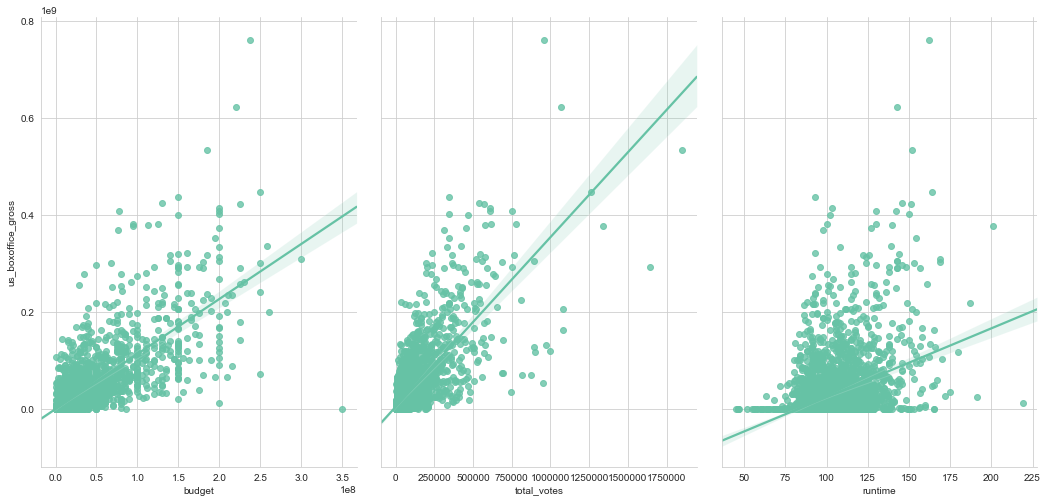

In [21]:
#scatter plot us_boxoffice_gross vs. budget, total_votes, runtime
sns.pairplot(data = imdb_df, x_vars = ['budget', 'total_votes', 'runtime'], 
             y_vars = 'us_boxoffice_gross',size = 7, aspect = 0.7, kind='reg')
plt.show()

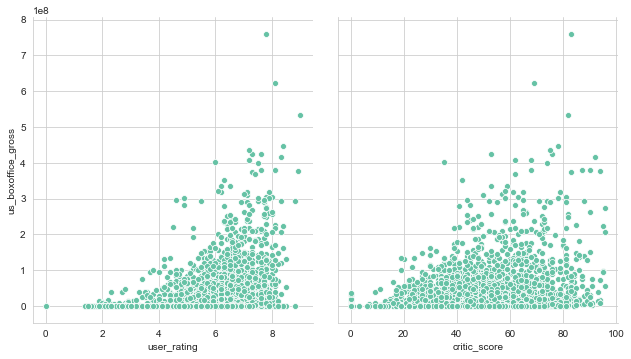

In [22]:
sns.pairplot(data = imdb_df, x_vars = ['user_rating', 'critic_score'], y_vars = 'us_boxoffice_gross', 
             size = 5, aspect = 0.9)
plt.show()

### Relationship with categorical features

#### Mpaa rating vs Box office

In [23]:
imdb_df.columns

Index(['id', 'title', 'genre', 'runtime', 'release_dt', 'budget',
       'us_boxoffice_gross', 'mpaa_rating', 'user_rating', 'total_votes',
       'critic_score', 'new_release_month'],
      dtype='object')

In [24]:
imdb_df.mpaa_rating.value_counts()

R            1723
PG           1403
Not Rated    1206
G              60
Name: mpaa_rating, dtype: int64

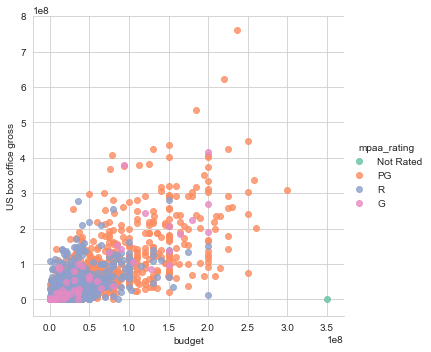

In [25]:
# Box plot mpaa_rating/us_boxoffice_gross
fig2 = sns.lmplot(x="budget", y="us_boxoffice_gross", hue="mpaa_rating", fit_reg=False, data=imdb_df)
fig2.set(xlabel='budget', ylabel= 'US box office gross')

#### Genre vs Box office

Ignoring genre since there are too many categories to unpack: > 90 categories (eg. Action vs action Adventure vs
Action, Adventure, Biography vs Action, Adventure, Crime

#### Release month vs Box office

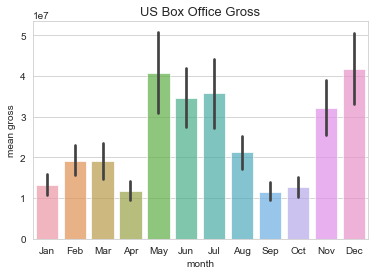

In [26]:
#box plot new_release_month/us_boxoffice_gross
var = 'new_release_month'
data = pd.concat([imdb_df['us_boxoffice_gross'], imdb_df[var]], axis=1)
fig = sns.barplot(x=var, y="us_boxoffice_gross", data=data, order=['Jan','Feb','Mar','Apr',
                                                'May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], alpha=0.7)
fig.set_title('US Box Office Gross', fontsize=13)
fig.set(xlabel = 'month' , ylabel ='mean gross')
plt.show()

#### Time Series

In [27]:
## Unused
# # For ease of calculating responses over time, add a count colum for each response and set timestamp as index
# results["count"] = 1
# total_results = results.set_index('timestamp')

# # TimeGrouper to group by day
# running_results = total_results.groupby(pd.TimeGrouper('D'))["count"].count().cumsum()
# running_results

# # label x-axis by defining time range as a series from 0 to max number of days.
# step = pd.Series(range(0,len(running_results)), name="Days")
# sns.tsplot(running_results, value="Total Responses", time=step, color="husl")


### VI) Output data to CSV

In [28]:
imdb_df.columns

Index(['id', 'title', 'genre', 'runtime', 'release_dt', 'budget',
       'us_boxoffice_gross', 'mpaa_rating', 'user_rating', 'total_votes',
       'critic_score', 'new_release_month'],
      dtype='object')

In [29]:
# out to csv for regression analysis - continued on regression ipynb
imdb_df.to_csv('imdb_df_clean.csv', sep='\t', encoding='utf-8')

In [30]:
# # Get all columns names from dataframe - create a Python list of feature names
# feature_cols = imdb_df.columns.tolist()

# # Filter columns (remove ones that have no meaning)
# feature_cols  = [c for c in feature_cols if c not in ['us_boxoffice_gross','id','title', 'new_release_month']]

# # use the list to select a subset of the original DataFrame
# X = imdb_df[feature_cols]
# y = imdb_df['us_boxoffice_gross']
# pd.concat([X, y], axis=1).to_csv('imdb_df_clean.csv', sep='\t', encoding='utf-8')

### VII) Questions

A list of questions that were asked before EDA
1. Is there a relationship between boxoffice gross and budget?
2. How strong is the relationship?
3. How about genre? What types of genres influence gross the most? (positively and negatively)
4. Does time of release make a difference on the gross and has that changed over a period of time?
5. Can us_boxoffice_gross be predicted based on the given factors?